# Computational Finance
## 1. Consider the following bond market information for a set of Treasury government bonds:

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import numpy_financial as npf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy.random as npr

In [2]:
maturities = range(1,11)
prices = [96.6, 93.71, 91.56, 90.24, 89.74, 90.04, 91.09, 92.82, 95.19, 98.14]
coupons = np.linspace(1.5, 3.75, 10)


## Build a class called YieldCurve that will receive an array with information on maturity, price and coupon for n bonds (n x 3):
## - Add a method that will bootstrap the discount factors using matrix operations
## - Add a method that will bootstrap the discount factors using a global solver
## - Add a method that will bootstrap the discount factors using an iterative procedure

In [3]:
bonds = np.array([maturities, prices, coupons])
bonds

array([[ 1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
        10.  ],
       [96.6 , 93.71, 91.56, 90.24, 89.74, 90.04, 91.09, 92.82, 95.19,
        98.14],
       [ 1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,
         3.75]])

In [4]:
#We will create a class with all the functions with the different methods
class YieldCurve():
    def __init__(self, bonds):
        self.maturity, self.price, self.coupon = bonds
    def matrix(self):
       cfs =  np.tri(len(bonds.T))*self.coupon.reshape(-1,1) + np.eye(len(bonds.T))*100 # we calculate the cash flows using a matrix
       df = np.linalg.inv(cfs) @ self.price # we calculate the discount factors based on the inverse matrix of the cash flows
       return df # the function returns the final result that is the discount factor
    def globalsol(self):
        def bond_price(coupon, df):
            years = len(bonds.T) # we calculate the maturity in years
            cfs =  np.tri(len(bonds.T))*self.coupon.reshape(-1,1) + np.eye(len(bonds.T))*100 # we calculate the cash flows
            price = {k:[] for k in range(0, len(bonds.T))} # we create the list of prices
            for n in range(years): # we loop inside the maturity
                for i in range(years):
                    p = cfs[n,i]*df[i] # we multiply the cash flows by the discount factors
                    price[n].append(p) # we append to the price (p)  calculated in the previous line to the price list
                    
            return np.array(pd.DataFrame(price).T.sum(axis = 1)) # the function returns the price list in a DataFrame

        def error(df, x, y):  #in case of an error we will receive the bond price powered by 2 and suming it all
            return ((bond_price(coupons, df) - y)**2).sum()  
        
        df0 = npr.rand(len(bonds.T))
        df = minimize(error, df0, args = (self.coupon, self.price))['x']
        return df
        
    def iterative(self):
        years = len(bonds.T) # we calculate the maturity in years
        cfs =  np.tri(len(bonds.T))*self.coupon.reshape(-1,1) + np.eye(len(bonds.T))*100 # we calculate the cash flows
        dfs = np.zeros((10,10)) #we create a discount factor matrix 10 for 10 with zeros
        for k in range(0,years): 
            dfs[k,k] = (self.price[k]-dfs[k].sum())/cfs[k,k] #We calculate the discount factors for every price on the matrix by subtracting the discount factor to the price, summing the results and diving by the cashflows 
            for i in range(k+1, years):
                dfs[i,k] = cfs[i,0]*dfs[k,k] # we calculate the the discount factors but this time for the year after  
        df = [] #create an empty list
        for i in range(0,years):    
            df.append(dfs[i,i]) #fill the list with the discount factors
        return np.array(df) # the function returns the final result that is the discount factor


In [5]:
#Result of the matrix method
dfbonds = YieldCurve(bonds).matrix()
dfbonds

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

In [6]:
#Result of the global solver method
dfbondsg = YieldCurve(bonds).globalsol()
dfbondsg

array([0.95172413, 0.90461408, 0.86124826, 0.82274259, 0.7891627 ,
       0.76042722, 0.73611886, 0.71559686, 0.69849544, 0.68423625])

In [7]:
#Result of the iterative method
dfbondsi = YieldCurve(bonds).iterative()
dfbondsi

array([0.95172414, 0.90461408, 0.86124827, 0.8227426 , 0.78916271,
       0.76042723, 0.73611886, 0.71559687, 0.69849544, 0.68423626])

In [8]:
#We will put all the solutions from all the methods in one dataframe
dfmethods = pd.DataFrame(dfbonds, columns=['matrix'] , index = maturities)
dfmethods['global']= dfbondsg.tolist()
dfmethods['iterative']= dfbondsi.tolist()
dfmethods

,matrix,global,iterative
1,0.951724,0.951724,0.951724
2,0.904614,0.904614,0.904614
3,0.861248,0.861248,0.861248
4,0.822743,0.822743,0.822743
5,0.789163,0.789163,0.789163
6,0.760427,0.760427,0.760427
7,0.736119,0.736119,0.736119
8,0.715597,0.715597,0.715597
9,0.698495,0.698495,0.698495
10,0.684236,0.684236,0.684236


## Determine the spot rate (annual compounding) for each maturity from the calculated discount factors and plot them

In [9]:
#We will calculate the spot rate for each maturity
df = pd.DataFrame(dfbonds, columns=['df'], index = maturities) #create a dataframe with the discount factors using the maturity as an index
df['spot'] = [pow(1/d, 1/(m+1)) - 1 for m,d in enumerate(dfbonds)] #we calculate the spot rate, by powering the the first parameter with the second parameter and add it to the dataframe 
df

,df,spot
1,0.951724,0.050725
2,0.904614,0.051401
3,0.861248,0.051051
4,0.822743,0.049987
5,0.789163,0.048496
6,0.760427,0.046704
7,0.736119,0.044738
8,0.715597,0.042717
9,0.698495,0.040675
10,0.684236,0.038674


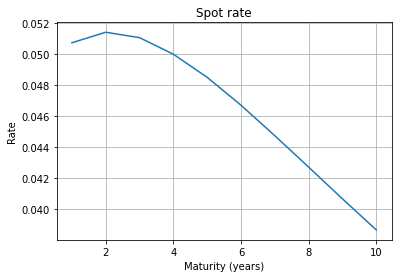

In [10]:
#We will plot the line of the spot rates
plt.plot(df['spot'])
plt.title('Spot rate')
plt.xlabel('Maturity (years)')
plt.ylabel('Rate')
plt.grid()

## Determine the YTM for each bond and plot them

In [11]:
#We will calculate the Yield to Maturity
cfs =  np.tri(10) * coupons.reshape(-1,1) + np.eye(10) * 100 #We calculate the cashflows
data = np.column_stack((-np.array(prices), cfs)) #We create a matrix based on the price and cashflows stacking them
df['yield'] =[npf.irr(bond) for bond in data] #We calculate the yields for each row (bond), based on the previous array created
df

,df,spot,yield
1,0.951724,0.050725,0.050725
2,0.904614,0.051401,0.051395
3,0.861248,0.051051,0.051054
4,0.822743,0.049987,0.050026
5,0.789163,0.048496,0.048607
6,0.760427,0.046704,0.046931
7,0.736119,0.044738,0.045127
8,0.715597,0.042717,0.043311
9,0.698495,0.040675,0.041514
10,0.684236,0.038674,0.039791


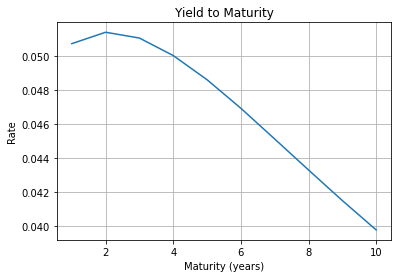

In [12]:
#We will plot the line of the yield rates
plt.plot(df['yield'])
plt.title('Yield to Maturity')
plt.xlabel('Maturity (years)')
plt.ylabel('Rate')
plt.grid()

## Determine the 1y forward rate starting in each of the years from 1 to 9 and plot them

In [13]:
#Calculate the forward rate for each maturity
f_rate = [] #Create an empty list

for i in maturities: #Loop for every maturity
    if i < 10: #When the maturity is smaller than 10
        fr = ((1+df['spot'][i+1])**(i+1)/(1+df['spot'][i])**(i))-1 #We calculate the forward rate by using the spot rates
        f_rate.append(fr) #append to the list the results
    else:
        f_rate.append(np.nan) #if maturity is higher than 9 we add NaN value


df['forward'] = f_rate #We add to the dataframe the forward rate
df

,df,spot,yield,forward
1,0.951724,0.050725,0.050725,0.052078
2,0.904614,0.051401,0.051395,0.050352
3,0.861248,0.051051,0.051054,0.046802
4,0.822743,0.049987,0.050026,0.042551
5,0.789163,0.048496,0.048607,0.037789
6,0.760427,0.046704,0.046931,0.033022
7,0.736119,0.044738,0.045127,0.028678
8,0.715597,0.042717,0.043311,0.024483
9,0.698495,0.040675,0.041514,0.020840
10,0.684236,0.038674,0.039791,NaN


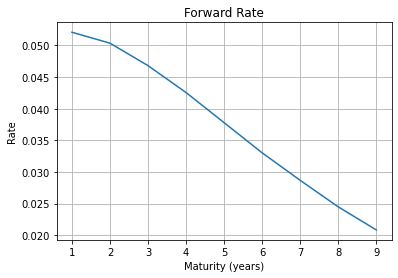

In [14]:
#We will plot the line of the yield rates
plt.plot(df['forward']) 
plt.title('Forward Rate')
plt.xlabel('Maturity (years)')
plt.ylabel('Rate')
plt.grid()

## Make a plot of the spot rates, yields and forward rates with a legend identifying the series

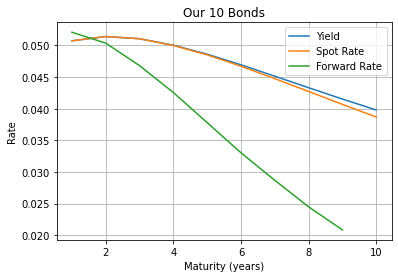

In [15]:
#we plot the Yield, spot and forward rates in a line chart all together. 
plt.plot(df[['yield', 'spot', 'forward']])
plt.title('Our 10 Bonds')
plt.xlabel('Maturity (years)')
plt.ylabel('Rate')
plt.legend(['Yield', 'Spot Rate', 'Forward Rate'])
plt.grid()

# Computational Finance - GROUP ASSIGNMENT, 2022-23
## DataFrames: write python code for the following tasks

### A - [1.0] Get historical data (close price and volume) for 5 stocks of your choice using any API of your choice from 2012 to the present time [we consider 10Y from 30.12.2011-31.12.2021]
#### Step 1 - Get data from Yahoo Finance
#### Group choice is for 5 global steel Competitors: Gerdau, CSN, Nucor, SteelDynamics and Commercial Metals
#### Load the matplotlib, pandas and numpy to work with datas:

In [16]:
#We are using the Yahoo Finance API to download the historical data of 5 stocks
import yfinance as yf
materials = yf.download("GGB SID NUE STLD CMC", start="2011-12-30", end="2021-12-31") #We download the historical data of the 5 stock price between the dates 2012-12-30 and 2021-12-31

[*********************100%***********************]  5 of 5 completed


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [18]:
materials #we see the dataframe of the stock prices

Adj Close                                                 Close  \
                  CMC       GGB         NUE       SID       STLD        CMC   
Date                                                                          
2011-12-30  10.394145  5.671319   28.993080  5.314113  10.047064  13.830000   
2012-01-03  10.454272  6.005353   29.689167  5.684412  10.719413  13.910000   
2012-01-04  10.860118  6.114277   29.952942  5.742880  11.063228  14.450000   
2012-01-05  10.837569  6.077971   30.004227  5.606453  11.002104  14.420000   
2012-01-06  11.265963  6.165110   30.165422  5.541490  11.055588  14.990000   
...               ...       ...         ...       ...        ...        ...   
2021-12-23  34.572075  4.484118  112.371269  4.112448  60.551594  35.080002   
2021-12-27  35.054977  4.559799  114.681610  4.179239  61.622177  35.570000   
2021-12-28  35.488605  4.550338  112.518730  4.179239  61.190010  36.009998   
2021-12-29  35.882816  4.503038  112.951317  4.131531  61.258766  36.410000   
2021-12-30  35.429478  4.626019  112.418098  4.246030  61.031918  35.950001   

                                               ...       Open        \
             GGB         NUE   SID       STLD  ...        CMC   GGB   
Date                                           ...                    
2011-12-30  7.81   39.570000  8.18  13.150000  ...  13.740000  7.72   
2012-01-03  8.27   40.520000  8.75  14.030000  ...  13.990000  8.12   
2012-01-04  8.42   40.880001  8.84  14.480000  ...  13.830000  8.16   
2012-01-05  8.37   40.950001  8.63  14.400000  ...  14.320000  8.46   
2012-01-06  8.49   41.169998  8.53  14.470000  ...  14.500000  8.53   
...          ...         ...   ...        ...  ...        ...   ...   
2021-12-23  4.74  114.300003  4.31  61.650002  ...  34.400002  4.76   
2021-12-27  4.82  116.650002  4.38  62.740002  ...  35.049999  4.76   
2021-12-28  4.81  114.449997  4.38  62.299999  ...  35.450001  4.76   
2021-12-29  4.76  114.889999  4.33  62.369999  ...  36.200001  4.79   
2021-12-30  4.89  113.849998  4.45  61.880001  ...  36.299999  4.87   

                                          Volume                             \
                   NUE   SID       STLD      CMC      GGB      NUE      SID   
Date                                                                          
2011-12-30   39.430000  8.04  13.150000   700400  2845900  1524100  1597900   
2012-01-03   40.540001  8.44  13.490000  1901700  6924400  3128000  5085400   
2012-01-04   40.410000  8.65  14.240000  2610700  5982900  2521300  4880700   
2012-01-05   40.509998  8.71  14.410000  1889400  8016600  2190200  3375100   
2012-01-06   40.980000  8.66  14.410000  5246800  9812700  3428200  3031800   
...                ...   ...        ...      ...      ...      ...      ...   
2021-12-23  113.709999  4.30  61.910000   611900  9041800  1191900  1547400   
2021-12-27  114.720001  4.35  61.880001   576100  5866500  1550600  2134000   
2021-12-28  114.290001  4.33  61.880001   552500  5429400  1524600  2095200   
2021-12-29  114.900002  4.38  62.299999   503100  5026100  1079000  1802500   
2021-12-30  114.660004  4.42  62.310001   550900  4390500  1348400  2122800   

                     
               STLD  
Date                 
2011-12-30  1273700  
2012-01-03  3268900  
2012-01-04  5672600  
2012-01-05  2688200  
2012-01-06  2534100  
...             ...  
2021-12-23  1034000  
2021-12-27   680400  
2021-12-28   815400  
2021-12-29  1183600  
2021-12-30   651000  

[2517 rows x 30 columns]

In [19]:
# Create a dataframe with Adjusted Close and Volume columns
materials = pd.DataFrame(materials) #Create a dataframe
materials.drop(['Close','Open', 'High', 'Low'], axis=1) #We drop the columns we dont want to work with

Adj Close                                              Volume  \
                  CMC       GGB         NUE       SID       STLD      CMC   
Date                                                                        
2011-12-30  10.394145  5.671319   28.993080  5.314113  10.047064   700400   
2012-01-03  10.454272  6.005353   29.689167  5.684412  10.719413  1901700   
2012-01-04  10.860118  6.114277   29.952942  5.742880  11.063228  2610700   
2012-01-05  10.837569  6.077971   30.004227  5.606453  11.002104  1889400   
2012-01-06  11.265963  6.165110   30.165422  5.541490  11.055588  5246800   
...               ...       ...         ...       ...        ...      ...   
2021-12-23  34.572075  4.484118  112.371269  4.112448  60.551594   611900   
2021-12-27  35.054977  4.559799  114.681610  4.179239  61.622177   576100   
2021-12-28  35.488605  4.550338  112.518730  4.179239  61.190010   552500   
2021-12-29  35.882816  4.503038  112.951317  4.131531  61.258766   503100   
2021-12-30  35.429478  4.626019  112.418098  4.246030  61.031918   550900   

                                                
                GGB      NUE      SID     STLD  
Date                                            
2011-12-30  2845900  1524100  1597900  1273700  
2012-01-03  6924400  3128000  5085400  3268900  
2012-01-04  5982900  2521300  4880700  5672600  
2012-01-05  8016600  2190200  3375100  2688200  
2012-01-06  9812700  3428200  3031800  2534100  
...             ...      ...      ...      ...  
2021-12-23  9041800  1191900  1547400  1034000  
2021-12-27  5866500  1550600  2134000   680400  
2021-12-28  5429400  1524600  2095200   815400  
2021-12-29  5026100  1079000  1802500  1183600  
2021-12-30  4390500  1348400  2122800   651000  

[2517 rows x 10 columns]

## B - [1.0] Plot the cumulative returns of the stocks on a single chart
#### Create a table with only the column 'Adj Close'
#### Calculate the returns with pct_change method
#### Calculate the cumulative return with cumprod method
#### Plot the cumulative return

In [20]:
#Plot the cumulative returns
matclose = materials[['Adj Close']].copy() #We create a new dataframe using only the adjusted Close values of the dataframe
matclose

Adj Close                                           
                  CMC       GGB         NUE       SID       STLD
Date                                                            
2011-12-30  10.394145  5.671319   28.993080  5.314113  10.047064
2012-01-03  10.454272  6.005353   29.689167  5.684412  10.719413
2012-01-04  10.860118  6.114277   29.952942  5.742880  11.063228
2012-01-05  10.837569  6.077971   30.004227  5.606453  11.002104
2012-01-06  11.265963  6.165110   30.165422  5.541490  11.055588
...               ...       ...         ...       ...        ...
2021-12-23  34.572075  4.484118  112.371269  4.112448  60.551594
2021-12-27  35.054977  4.559799  114.681610  4.179239  61.622177
2021-12-28  35.488605  4.550338  112.518730  4.179239  61.190010
2021-12-29  35.882816  4.503038  112.951317  4.131531  61.258766
2021-12-30  35.429478  4.626019  112.418098  4.246030  61.031918

[2517 rows x 5 columns]

In [21]:
day_returns = matclose.pct_change() #We do the percentage of difference between the the row and the previous row
day_returns

Adj Close                                        
                 CMC       GGB       NUE       SID      STLD
Date                                                        
2011-12-30       NaN       NaN       NaN       NaN       NaN
2012-01-03  0.005785  0.058899  0.024009  0.069682  0.066920
2012-01-04  0.038821  0.018138  0.008885  0.010286  0.032074
2012-01-05 -0.002076 -0.005938  0.001712 -0.023756 -0.005525
2012-01-06  0.039529  0.014337  0.005372 -0.011587  0.004861
...              ...       ...       ...       ...       ...
2021-12-23  0.016222 -0.016597  0.005808 -0.002315  0.003255
2021-12-27  0.013968  0.016878  0.020560  0.016241  0.017681
2021-12-28  0.012370 -0.002075 -0.018860  0.000000 -0.007013
2021-12-29  0.011108 -0.010395  0.003845 -0.011416  0.001124
2021-12-30 -0.012634  0.027311 -0.004721  0.027714 -0.003703

[2517 rows x 5 columns]

In [22]:
# Calculate the cumulative daily returns
cum_returns = day_returns
cum_returns = (1 + cum_returns).cumprod() - 1
cum_returns.columns = cum_returns.columns.droplevel()
cum_returns

,CMC,GGB,NUE,SID,STLD
Date,,,,,
2011-12-30,NaN,NaN,NaN,NaN,NaN
2012-01-03,0.005785,0.058899,0.024009,0.069682,0.066920
2012-01-04,0.044830,0.078105,0.033107,0.080685,0.101140
2012-01-05,0.042661,0.071703,0.034875,0.055012,0.095057
2012-01-06,0.083876,0.087068,0.040435,0.042787,0.100380
...,...,...,...,...,...
2021-12-23,2.326111,-0.209334,2.875796,-0.226127,5.026795
2021-12-27,2.372570,-0.195990,2.955482,-0.213558,5.133352
2021-12-28,2.414288,-0.197658,2.880882,-0.213558,5.090338


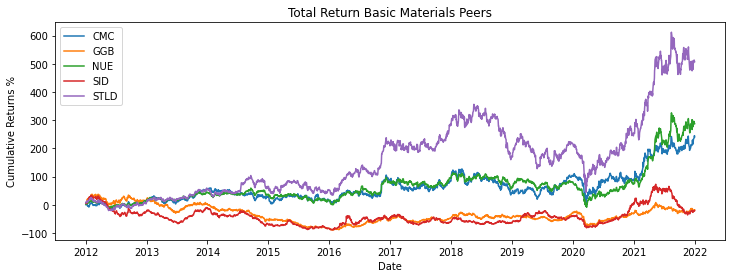

In [23]:
plt.figure(figsize=(12,4))
# Plot the returns for each stock price
plt.plot(cum_returns*100)
# Give the axes labels
plt.legend(cum_returns.columns)
plt.ylabel('Cumulative Returns %')
plt.xlabel('Date')
plt.title('Total Return Basic Materials Peers')
plt.show()

## c) [1.0] Create the correlation matrix of the daily returns
#### Use the corr method

In [24]:
#Create the correlation matrix for returns
df = day_returns.corr() #Correlation matrix
df.style.background_gradient(cmap='coolwarm')

### Makes sense:
#### Gerdau(GGB) and CSN(SID) are national competitors in Brazil (high correlation)
#### Nucor (NUE), Commercial Metals (CMC) and SteelDynamics (STLD) are national competitors in USA (high correlation)

## d) [1.0] Save the data (close price and volume) to a CSV file for each ticker

In [25]:
# Create the list of the tickers 
tickers = cum_returns.columns #return the tickers from the cum_returns
tickers = tickers.values.tolist() 

In [26]:
tickers

['CMC', 'GGB', 'NUE', 'SID', 'STLD']

In [27]:
# Generate the files
import csv
for i in tickers:
    stock = yf.download(i, start="2011-12-30", end="2021-12-31") #Download the data between that dates
    stock = stock[['Close','Volume']].copy() #Only using the Close and Volume columns
    stock.reset_index(inplace=True) #Rename the index
    filename=i+( '.csv') #Rename the filename with the tickers
    with open(filename, 'w') as f:
        # create the csv writer
        writer = csv.writer(f)
        writer.writerow(stock.columns)
        # write a row to the csv file
        for idx, row in stock.iterrows():
            writer.writerow(stock.loc[idx])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## e) [1.0] Load the data from the CSV files you saved into a single DataFrame with the prices for each ticker

In [28]:
#We will load only the price for each ticket
price = pd.DataFrame()  #Creta and empty dataframe
for i in tickers:
    filename=i+( '.csv') #Read all the files that are csv
    stock = pd.read_csv(filename) #Read the file
    stock.set_index('Date', inplace=True) #Use the date as an index
    stock = stock[['Close']].copy() #Only use the Close column
    stock.rename(columns = {'Close':i}, inplace = True) #Rename the column by the ticket name
    price[i] = stock #Fill the dataframe with the data imported
price

,CMC,GGB,NUE,SID,STLD
Date,,,,,
2011-12-30 00:00:00,13.830000,7.81,39.570000,8.18,13.150000
2012-01-03 00:00:00,13.910000,8.27,40.520000,8.75,14.030000
2012-01-04 00:00:00,14.450000,8.42,40.880001,8.84,14.480000
2012-01-05 00:00:00,14.420000,8.37,40.950001,8.63,14.400000
2012-01-06 00:00:00,14.990000,8.49,41.169998,8.53,14.470000
...,...,...,...,...,...
2021-12-23 00:00:00,35.080002,4.74,114.300003,4.31,61.650002
2021-12-27 00:00:00,35.570000,4.82,116.650002,4.38,62.740002
2021-12-28 00:00:00,36.009998,4.81,114.449997,4.38,62.299999
